In [1]:
%matplotlib inline
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import math
import pylab as py
import sys
import numpy.ma as ma
from decimal import Decimal
import os
from importlib import reload
import h5py

In [2]:
plt.style.use('ggplot')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['text.usetex']=True

In [3]:
filepath = "/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_new_visc.scratch/pixie3d.h5"

In [4]:
import pixie_read_st as pxr

In [5]:
pxr.pixieload(filepath)

timesteps= 41
Dictionary of terms:
Variables: ['Car_variables', 'Cnv_variables', 'Cov_variables', 'Diagnostics', 'Perturbations', 'cells', 'nodes']
Cartesian: ['Bx', 'By', 'Bz', 'Jx', 'Jy', 'Jz', 'Prs', 'Ve_1', 'Ve_2', 'Ve_3', 'Vx', 'Vy', 'Vz', 'rho']
Contravariant: ['B^1', 'B^2', 'B^3', 'J*P^2', 'J.(pi+pe)', 'J.Rho', 'J^1', 'J^2', 'J^3', 'P^1', 'P^3']
Covariant: ['B_1', 'B_2', 'B_3', 'J_1', 'J_2', 'J_3', 'T=Te+Ti', 'V_1', 'V_2', 'V_3', 'rho']
Diagnostic: ['E_1', 'E_2', 'E_3', 'Int. heat src', 'Poloidal flux', 'Temperature', 'V.(b x grad(psi))', 'V.grad(psi)', 'V||', 'chi par', 'chi perp', 'diff', 'eta', 'lambda', 'local div(B)', 'local div(J)', 'local div(V)', 'nu', 'q factor']
Perturbations: ['B^1_pert', 'B^2_pert', 'B^3_pert', 'P^1_pert', 'P^2_pert', 'P^3_pert', 'Prs_pert', 'Rho_pert']


## Saving B-field contravariant arrays

In [2]:
pxr.X.shape

NameError: name 'pxr' is not defined

In [118]:
np.save("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_new_visc.scratch/Z.npy",pxr.Z)

In [102]:
B2 = pxr.load_array(1,1,None,None)

In [103]:
B2.shape

(128, 65, 33, 40)

In [104]:
np.save("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_new_visc.scratch/B2.npy",B2)

## Test the Julia-created array

In [6]:
b_hat_rho = np.load("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_new_visc.scratch/b_hat_rho_nc.npy")

In [7]:
b_hat_rho.shape

(100, 100, 33, 40)

In [8]:
dphi = 2*np.pi/b_hat_rho.shape[2]
dtheta = 2*np.pi/b_hat_rho.shape[1]

In [9]:
N_p = b_hat_rho.shape[2]
dt_p = dphi
T_p = dt_p*N_p
df_p = 1/T_p
dw_p = 2*np.pi/T_p
freq_p = np.fft.fftfreq(N_p)

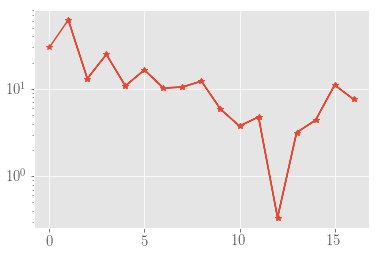

In [11]:
fou_p = np.fft.fft(b_hat_rho[5,10,:,30])
plt.semilogy(abs(freq_p*N_p*dw_p),abs(fou_p)**2,'*-')
plt.show()

In [12]:
N_t = b_hat_rho.shape[1]
dt_t = dtheta
T_t = dt_t*N_t
df_t = 1/T_t
dw_t = 2*np.pi/T_t
freq_t = np.fft.fftfreq(N_t)

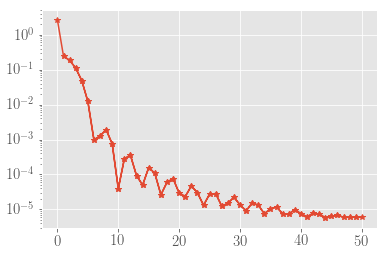

In [14]:
fou_t = np.fft.fft(b_hat_rho[5,:,0,30])
plt.semilogy(abs(freq_t*N_t*dw_t),abs(fou_t)**2,'*-')
plt.show()

In [85]:
b_tilda = []
for r in range(b_hat_rho.shape[0]):
    for uf in range(b_hat_rho.shape[1]):
        b_tilda.append(np.fft.fft(b_hat_rho[r,uf,:,12]))
b_tilda = np.reshape(b_tilda,(b_hat_rho.shape[0],b_hat_rho.shape[1],b_hat_rho.shape[2]))

In [86]:
b_tilda2 = []
for r in range(b_hat_rho.shape[0]):
    b_tilda2.append(np.fft.fft(b_tilda[r,:,1]))
b_tilda2 = np.reshape(np.asarray(b_tilda2),(b_hat_rho.shape[0],b_hat_rho.shape[1]))

In [87]:
psi = np.linspace(0,1,100)

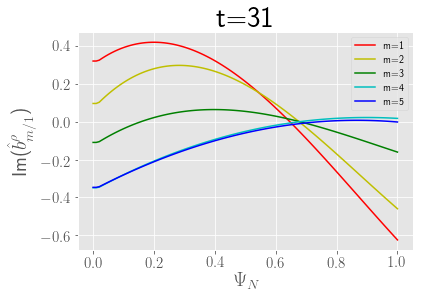

In [88]:
plt.title('t=31')
#plt.plot(psi,np.asarray(b_tilda2[:,0]).imag,'r',label='m=0')
plt.plot(psi,np.asarray(b_tilda2[:,1]).imag,'r',label='m=1')
plt.plot(psi,np.asarray(b_tilda2[:,2]).imag,'y',label='m=2')
plt.plot(psi,np.asarray(b_tilda2[:,3]).imag,'g',label='m=3')
plt.plot(psi,np.asarray(b_tilda2[:,4]).imag,'c',label='m=4')
plt.plot(psi,np.asarray(b_tilda2[:,5]).imag,'b',label='m=5')
plt.xlabel(r'$\Psi_N$')
plt.ylabel(r'Im($\hat{b}^{\rho}_{m/1}$)')
plt.legend()
plt.show()

In [20]:
bfft = []
for r in range(b_hat_rho.shape[0]):
    for uf in range(b_hat_rho.shape[1]):
        for time in range(b_hat_rho.shape[3]):
            bfft.append(np.fft.fft(b_hat_rho[r,uf,:,time]))
bfft = np.reshape(np.asarray(bfft),(b_hat_rho.shape[0],b_hat_rho.shape[1],b_hat_rho.shape[3],b_hat_rho.shape[2]))
bfft = np.swapaxes(bfft,2,3)

In [21]:
bfft1 = []
for r in range(b_hat_rho.shape[0]):
    for time in range(b_hat_rho.shape[3]):
        bfft1.append(np.fft.fft(bfft[r,:,1,time]))
bfft1 = np.reshape(np.asarray(bfft1),(100,40,100))
bfft1 = np.swapaxes(bfft1,1,2)

In [24]:
time = np.linspace(0,41,40)

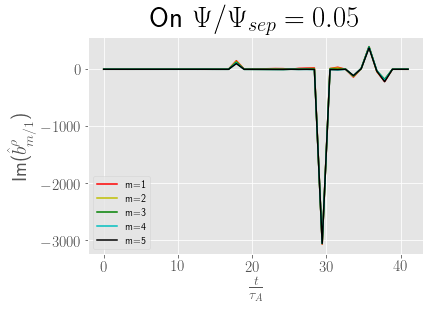

In [89]:
plt.title(r"On $\Psi/\Psi_{sep} =  0.05$")
plt.plot(time,bfft1[15,1,:].imag,'r',label='m=1')
plt.plot(time,bfft1[15,2,:].imag,'y',label='m=2')
plt.plot(time,bfft1[15,3,:].imag,'g',label='m=3')
plt.plot(time,bfft1[15,4,:].imag,'c',label='m=4')
plt.plot(time,bfft1[15,5,:].imag,'k',label='m=5')
#plt.axvline(x=440)
#plt.axvline(x=607)
plt.xlabel(r'$\frac{t}{\tau_A}$')
plt.ylabel(r'Im($\hat{b}^{\rho}_{m/1}$)')
plt.legend()
plt.show()

## Loading B-arrays

In [6]:
B1 = np.load("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_visc_neg.scratch/B1.npy")

In [7]:
B2 = np.load("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_visc_neg.scratch/B2.npy")

In [8]:
B3 = np.load("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_visc_neg.scratch/B3.npy")

## Normalizing $\Psi$

In [9]:
Psi = pxr.load_array(3,4,None,None)

In [10]:
Psi.shape

(129, 66, 34, 40)

In [11]:
Psi = pxr.f2c(Psi)

In [92]:
np.save("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_visc_neg.scratch/Psi_unorm.npy",Psi)

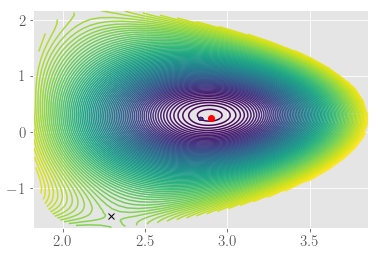

In [109]:
plt.contour(pxr.X[:,:,0],pxr.Z[:,:,0],Psi[:,:,0,0],100)
plt.plot(pxr.X[7,0,0],pxr.Z[7,0,0],'ro')
plt.plot(pxr.X[114,46,0],pxr.Z[114,46,0],'kx')
plt.show()

In [12]:
np.amin(Psi[:,0,0,0])

-0.0030128203568753017

In [13]:
Psi[114,46,0,0]

0.5341460400872815

In [14]:
reload(pxr)

<module 'pixie_read_st' from '/turquoise/users/giannis_kx/python_pixie/pixie_read_st.py'>

In [15]:
pxr.Initial_Psi_Normalization(Psi)

Initial psi normalization done...


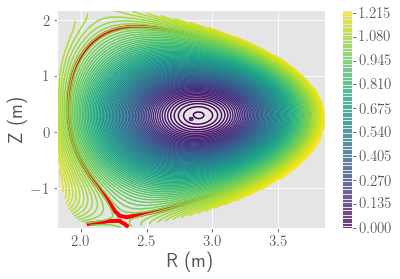

If the separatrix is in red, test passed.


In [16]:
pxr.test_psi_normalization()

In [115]:
pxr.P_N.shape

(128, 65, 33, 40)

In [116]:
np.save("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_new_visc.scratch/P_N.npy", pxr.P_N)

In [20]:
tmp = np.roll(pxr.P_N,-1,axis=1)

In [21]:
tmp[0,0,0,0]

0.207716013539018

In [18]:
pxr.P_N[110,11,12,13]

1.0361759274191449

## Interpolations

In [31]:
reload(pxr)

<module 'pixie_read_st' from '/turquoise/users/giannis_kx/python_pixie/pixie_read_st.py'>

In [19]:
pxr.Axes_of_Interpolation(Psi,B1)

In [27]:
pxr.Grid_Interpolations(pxr.P_N,B1,B2,B3)

Logical Grid Interpolations done. All array (A) interpolators take A_int.


In [28]:
pxr.Grids_Creation()

In [29]:
pxr.Grid_Evaluations()

Logical Grid Evaluations done. All grid evaluated interpolators take A_grid.


In [25]:
pxr.Psi_f

AttributeError: module 'pixie_read_st' has no attribute 'Psi_f'

## Derivatives

In [32]:
pxr.derivatives_and_interpolations()

Psi derivatives done...


In [36]:
pxr.dpdr[110,15,16]

0.70799876926913896

In [47]:
pxr.dpsidr_int((0.5,0,0))

array(0.8142184867241538)

In [52]:
pxr.Psi_grid.shape

(128, 65, 33, 1)

In [49]:
pxr.P_N[0,0,0]

array([ 0.20888351])

In [46]:
np.save("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_new_visc.scratch/dpdr.npy", pxr.dpdr)
np.save("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_new_visc.scratch/dpdt.npy", pxr.dpdt)

## Flux surface locator

In [42]:
reload(pxr)

<module 'pixie_read_st' from '/turquoise/users/giannis_kx/python_pixie/pixie_read_st.py'>

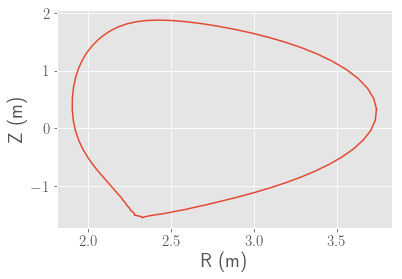

In [34]:
pxr.test_locator(1.001149845875)

In [43]:
#Calculate logical r on a the Psi_N grid
r_n = pxr.r_psi_list()

In [47]:
np.save("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_new_visc.scratch/r_of_psi.npy",r_n)

## Integrator test

In [26]:
import timeit

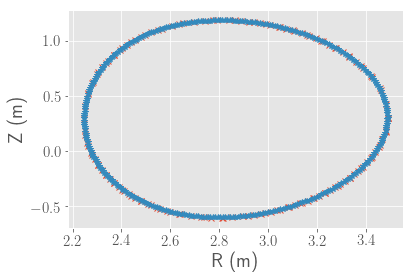

In [27]:
pxr.test_integrator(0.56)

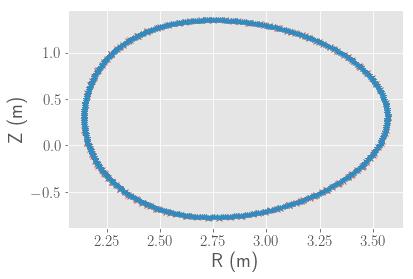

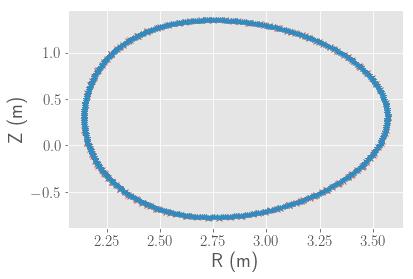

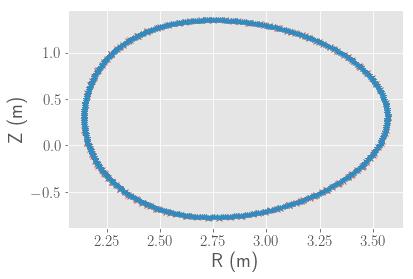

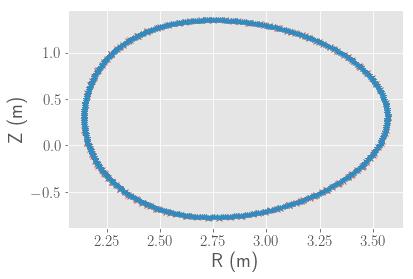

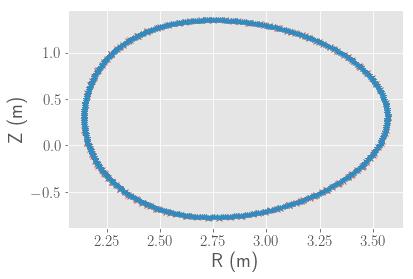

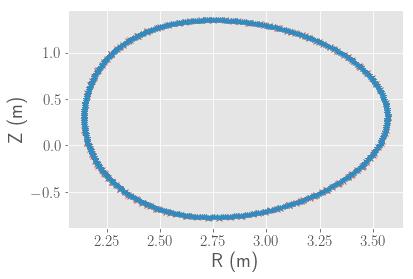

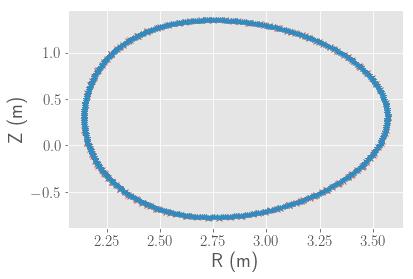

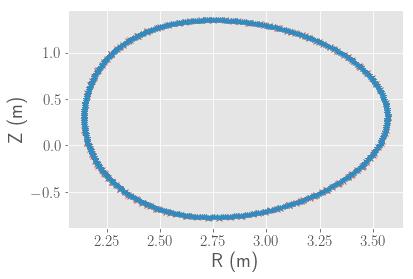

3.08 s ± 52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit
pxr.test_integrator(0.7)

In [84]:
%%timeit
pxr.test_integrator2(0.55)

q= -11.9339541372
q= -11.9339541372
q= -11.9339541372
q= -11.9339541372
q= -11.9339541372
q= -11.9339541372
q= -11.9339541372
q= -11.9339541372
6.28 s ± 263 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
reload(pxr)

<module 'pixie_read_st' from '/turquoise/users/giannis_kx/python_pixie/pixie_read_st.py'>

## Dictionary

In [55]:
pxr.Dictionary_Creation()

psi =  0.01
psi =  0.02
psi =  0.03
psi =  0.04
psi =  0.05
psi =  0.06
psi =  0.07
psi =  0.08
psi =  0.09
psi =  0.1
psi =  0.11
psi =  0.12
psi =  0.13
psi =  0.14
psi =  0.15
psi =  0.16
psi =  0.17
psi =  0.18
psi =  0.19
psi =  0.2
psi =  0.21
psi =  0.22
psi =  0.23
psi =  0.24
psi =  0.25
psi =  0.26
psi =  0.27
psi =  0.28
psi =  0.29
psi =  0.3
psi =  0.31
psi =  0.32
psi =  0.33
psi =  0.34
psi =  0.35
psi =  0.36
psi =  0.37
psi =  0.38
psi =  0.39
psi =  0.4
psi =  0.41
psi =  0.42
psi =  0.43
psi =  0.44
psi =  0.45
psi =  0.46
psi =  0.47
psi =  0.48
psi =  0.49
psi =  0.5
psi =  0.51
psi =  0.52
psi =  0.53
psi =  0.54
psi =  0.55
psi =  0.56
psi =  0.57
psi =  0.58
psi =  0.59
psi =  0.6
psi =  0.61
psi =  0.62
psi =  0.63
psi =  0.64
psi =  0.65
psi =  0.66
psi =  0.67
psi =  0.68
psi =  0.69
psi =  0.7
psi =  0.71
psi =  0.72
psi =  0.73
psi =  0.74
psi =  0.75
psi =  0.76
psi =  0.77
psi =  0.78
psi =  0.79
psi =  0.8
psi =  0.81
psi =  0.82
psi =  0.83
psi =  0.84


In [19]:
pxr.Load_Dictionary()

Dictionary loaded.


In [107]:
reload(pxr)

<module 'pixie_read_st' from '/turquoise/users/giannis_kx/python_pixie/pixie_read_st.py'>

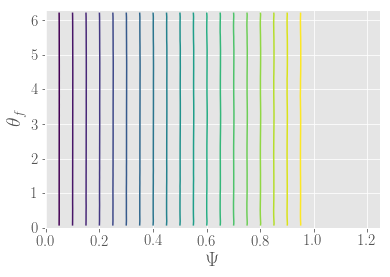

If field lines are straight, test passed.


In [20]:
li = pxr.test_psi_projection()

## Q-profile reconstruction

### $\theta_f$ on the logical grid

In [26]:
reload(pxr)

<module 'pixie_read_st' from '/turquoise/users/giannis_kx/python_pixie/pixie_read_st.py'>

In [21]:
fa = pxr.flux_angle()

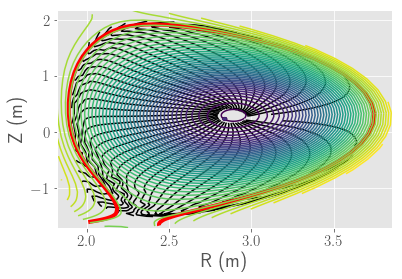

In [26]:
plt.contour(pxr.X[:,:,0],pxr.Z[:,:,0],fa[:,:],60,colors='k')
plt.contour(pxr.X[:,:,0], pxr.Z[:,:,0], Psi[:,:,0,0], levels = [.543], colors = 'r', linestyles = '-', linewidths = (4))
plt.contour(pxr.X[:,:,0],pxr.Z[:,:,0],Psi[:,:,0,0],60)
plt.xlabel('R (m)')
plt.ylabel('Z (m)')
#plt.axis('equal')
plt.show()

In [27]:
dfadr, dfadu = pxr.derivative_calculation_2d(fa)

### Q

In [29]:
denominator = np.multiply(B1[:,:,:,:],dfadr[:,:,np.newaxis,np.newaxis]) + np.multiply(B2[:,:,:,:],dfadu[:,:,np.newaxis,np.newaxis])

In [32]:
q = B3/denominator

In [33]:
q.shape

(128, 65, 33, 114)

In [38]:
Rline = [x for x in range(q.shape[0])]

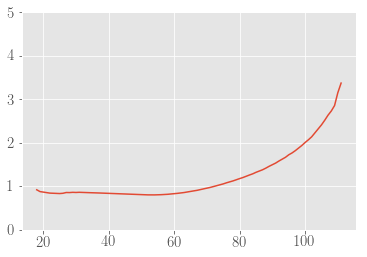

In [57]:
plt.plot(Rline,q[:,2,0,80])
plt.ylim(0,5)
plt.show()

## Velocities

In [40]:
Vx = np.asarray([f[ts][variables[0]][Car_var[10]] for ts in timesteps[0:-1]])
Vy = np.asarray([f[ts][variables[0]][Car_var[11]] for ts in timesteps[0:-1]])
Vz = np.asarray([f[ts][variables[0]][Car_var[12]] for ts in timesteps[0:-1]])

In [48]:
Vz = np.swapaxes(Vz,1,2)

In [50]:
Vz.shape

(129, 65, 33, 81)

In [51]:
import pixie_read_st as pxr

In [54]:
Vz = pxr.f2c(Vz)

In [55]:
Vx.shape

(128, 64, 32, 81)

In [56]:
V_plane = np.sqrt(np.power(Vx,2) + np.power(Vz,2))

In [57]:
from matplotlib import animation, rc
import matplotlib.animation as animation
import types
from IPython.display import HTML

In [58]:
def anim():
    fig,ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    ax.set_xlabel('R (m)')
    ax.set_ylabel('Z (m)')
    ims = []
    for time in range(81):
        im = ax.quiver(X[::6,:,0],Z[::6,:,0],Vx[::6,:,0,time],Vz[::6,:,0,time], edgecolor='k', facecolor='k',linewidth=.5,headwidth=8)
        text = 't = '+str(time)
        an = ax.annotate(text, xy=(0.8, 0.94), xycoords='axes fraction',fontsize=14)
        ims.append([im]+[an])
    art_ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000,blit=False)
    return art_ani

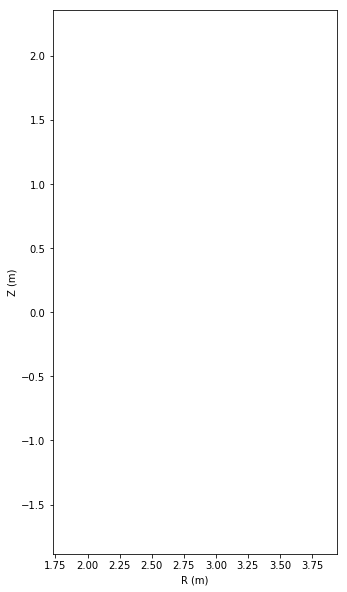

In [59]:
ani = anim()

In [60]:
HTML(ani.to_html5_video())

## Inspecting B1 array

In [23]:
B1.shape

(128, 65, 33, 41)

In [24]:
B1[99,9,9,9]

0.055359968341692802

In [25]:
B1.tofile("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_visc_neg.scratch/B1.bin")

In [34]:
B1F = np.asfortranarray(B1)

In [35]:
B1F.tofile("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_visc_neg.scratch/B1F.bin")

In [38]:
B1F.shape

(128, 65, 33, 41)

In [39]:
B1F[99,9,9,9]

0.055359968341692802

In [31]:
B1[0:9,0,0,0]

array([-0.00034392, -0.00102624, -0.00170057, -0.00236597, -0.00302129,
       -0.00366527, -0.00429656, -0.00491385, -0.00551596])

In [27]:
pxr.B1_int((0.8,2.2,2.2,30))

array(-0.044420112877662184)

In [28]:
pxr.X

array([[[ 2.84203029,  2.73281266,  2.51857457, ...,  2.73281266,
          2.84203029,  2.84203029],
        [ 2.84199188,  2.73277573,  2.51854053, ...,  2.73277573,
          2.84199188,  2.84199188],
        [ 2.84191544,  2.73270222,  2.51847279, ...,  2.73270222,
          2.84191544,  2.84191544],
        ..., 
        [ 2.84199188,  2.73277573,  2.51854053, ...,  2.73277573,
          2.84199188,  2.84199188],
        [ 2.84203029,  2.73281266,  2.51857457, ...,  2.73281266,
          2.84203029,  2.84203029],
        [ 2.84203029,  2.73281266,  2.51857457, ...,  2.73281266,
          2.84203029,  2.84203029]],

       [[ 2.85000606,  2.74048192,  2.5256426 , ...,  2.74048192,
          2.85000606,  2.85000606],
        [ 2.84989082,  2.74037111,  2.52554048, ...,  2.74037111,
          2.84989082,  2.84989082],
        [ 2.84966146,  2.74015057,  2.52533723, ...,  2.74015057,
          2.84966146,  2.84966146],
        ..., 
        [ 2.84989082,  2.74037111,  2.52554048, ...,

In [31]:
np.save("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_visc_neg.scratch/X.npy",pxr.X)
np.save("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_visc_neg.scratch/Z.npy",pxr.Z)
np.save("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_visc_neg.scratch/dpdr.npy",pxr.dpdr)
np.save("/net/scratch4/giannis_kx/pixie3d/iter/int_kink/11/11_visc_neg.scratch/dpdu.npy",pxr.dpdt)

In [79]:
l = [0,1,2,3,4,5]
r = [0,1,4,9,16,25]
rol = interp1d(l,r,kind='quadratic',fill_value='extrapolate')

In [84]:
rol(2.6)

array(6.76)

In [51]:
dict1 = h5py.File("/users/giannis_kx/Julia/julia_dict.jld","r")

In [52]:
list(dict1.keys())

['_creator', 'data', '_types', '_refs']

In [53]:
dict_set = dict1['data']

In [76]:
types_set = dict1['_types']

In [55]:
result = dict_set[()]

In [75]:
dict_set[("a","b")]["2"]

ValueError: Field a does not appear in this type.

In [81]:
for atr in types_set.attrs:
    print("atr:",atr.dtype)

In [82]:
pxr.

ModuleNotFoundError: No module named 'silx'